## 1. Análisis de componentes Principales

### 3.1. Estudie si es posible hacer transformaciones en las variables categóricas para incluirlas en el PCA, ¿valdrá la pena?

Transformaciones comunes para variables categóricas:
1.Codificación One-Hot (dummies):
   - Convierte cada categoría de una variable en una columna separada con valores binarios (0 o 1).
   - Ejemplo: Si tienes una variable "Color" con categorías "Rojo", "Verde" y "Azul", se crearán tres columnas: Color_Rojo, Color_Verde, Color_Azul.
   - Esto puede aumentar significativamente el número de características, lo cual podría dificultar la interpretación si el número de categorías es muy grande.

2.Codificación de etiquetas (Label Encoding):
   - Asigna un número único a cada categoría.
   - Ejemplo: Si "Rojo" = 1, "Verde" = 2, "Azul" = 3, la variable se convierte en una variable numérica.
   - Aunque esta es una opción más compacta, puede implicar que el modelo pueda interpretar las categorías como ordinales,
     lo cual no es apropiado si no hay un orden natural entre las categorías.
3.Codificación Binaria:
   - Convierte las categorías a su representación binaria, lo cual puede ser útil si el número de categorías es grande y se desea mantener la información en un espacio más compacto.

¿Vale la pena hacer estas transformaciones?
   - Si las variables categóricas tienen un impacto significativo en la variabilidad de los datos, transformarlas puede proporcionar una representación más rica y útil para el PCA.

In [17]:
import pandas as pd
import chardet

file_path = "movies.csv"

# Paso 1: Detectar la codificación
with open(file_path, "rb") as f:
    result = chardet.detect(f.read(100000))
    encoding_detected = result["encoding"]

print(f"Codificación detectada: {encoding_detected}")

# Paso 2: Intentar cargar el archivo con diferentes estrategias
try:
    df = pd.read_csv(file_path, encoding=encoding_detected, on_bad_lines="skip")
    print("Archivo cargado exitosamente con la codificación detectada.")
except Exception as e:
    print(f"Error con la codificación detectada ({encoding_detected}): {e}")

    # Alternativas de codificación
    encodings = ["utf-8", "ISO-8859-1", "latin1", "windows-1252"]
    for enc in encodings:
        try:
            df = pd.read_csv(file_path, encoding=enc, on_bad_lines="skip")
            print(f"Archivo cargado exitosamente con encoding: {enc}")
            break
        except Exception as e:
            print(f"Error con encoding {enc}: {e}")
    else:
        print("No se pudo leer el archivo con las codificaciones probadas.")

# Mostrar las primeras filas si se cargó correctamente
if "df" in locals():
    print(df.head())
else:
    print("No se pudo cargar el archivo.")




Codificación detectada: ISO-8859-1
Archivo cargado exitosamente con la codificación detectada.
                                                                                                                                                                                                                            Tom Holland|Ben Daniels|Bill Milner|Alice Lowe|Danny Webb|Lee Ross|Silas Carson|Kirsty Dillon"  \
210577 61000000 Mystery|Thriller|Drama          http://www.gonegirlmovie.com/ Regency Enterprises|New Regency Pictures|Pacifi... US|US||US|US|US United States of America 369330363.0 149 FALSE David Fincher                Ben Affleck|Rosamund Pike|Neil Patrick Harris|...                                               
210769 0        Family|Comedy|Mystery|Animation NaN                           Hanna-Barbera Productions                          US              United States of America 0.0         42  FALSE Jomac Noph                   Frank Welker|Stephanie D'Abruzzo|Grey DeLisle|..

### 3.2. Estudie si es conveniente hacer un Análisis de Componentes Principales. Recuerde que puede usar el índice KMO y el test de esfericidad de Bartlett.

El PCA es útil cuando se busca reducir la dimensionalidad sin perder una cantidad significativa de información. Para evaluar si es conveniente realizar PCA, se deben utilizar dos pruebas: el índice KMO (Kaiser-Meyer-Olkin) y el test de esfericidad de Bartlett.


1.Prueba de Esfericidad de Bartlett:
   - Se utiliza para verificar si las variables están correlacionadas lo suficiente como para realizar un análisis factorial (PCA).
   - Hipótesis nula: La matriz de correlación es una matriz identidad (lo que indica que no hay correlación significativa).
   - Si el valor p de la prueba es bajo (generalmente < 0.05), se puede proceder con PCA porque las variables están correlacionadas de manera significativa.

2.Índice KMO (Kaiser-Meyer-Olkin):
   - Mide la adecuación de la muestra para el análisis factorial.
   - El valor KMO varía entre 0 y 1, siendo:
        - Valor KMO cercano a 1 indica que los datos son adecuados para PCA.
        - Valor KMO menor que 0.5 indica que no es recomendable realizar PCA.



In [27]:
import pandas as pd
import numpy as np
from scipy.stats import chi2

# Supongamos que df es tu DataFrame original
df_encoded = df.select_dtypes(include=[np.number])  # Asegurar solo variables numéricas

def bartlett_test(df):
    # Calcular la matriz de correlación
    correlation_matrix = df.corr()
    n = len(df)  # Número de observaciones
    p = df.shape[1]  # Número de variables

    # Calcular el estadístico de Bartlett
    bartlett_stat = (n - 1 - (2 * p + 5) / 6) * np.log(np.linalg.det(correlation_matrix))

    # Grados de libertad
    df_bartlett = (p * (p - 1)) / 2
    p_value = 1 - chi2.cdf(bartlett_stat, df_bartlett)

    return bartlett_stat, p_value

# Ejecutar la prueba de Bartlett
bartlett_stat, p_value = bartlett_test(df_encoded)
print(f'Estadístico de Bartlett: {bartlett_stat}')
print(f'Valor p de Bartlett: {p_value}')



Estadístico de Bartlett: -763.4469218608922
Valor p de Bartlett: 1.0


In [29]:
import pandas as pd
import numpy as np
from factor_analyzer import calculate_kmo

# Asegurar que df_encoded contiene solo variables numéricas
df_encoded = df.select_dtypes(include=[np.number]).dropna()

# Calcular el índice KMO
kmo_all, kmo_model = calculate_kmo(df_encoded)
print(f'Índice KMO: {kmo_model}')


Índice KMO: 0.5864729678583378


### 3.3. Haga un análisis de componentes principales con las variables numéricas, discuta los resultados e interprete los componentes.

Una vez que se determina que es conveniente realizar PCA (basado en las pruebas anteriores), se procede con el análisis de los componentes principales utilizando solo las variables numéricas.


1.Pasos para realizar PCA:
   - Normalización de los datos: Si las variables numéricas tienen escalas diferentes, es necesario normalizarlas (por ejemplo, utilizando estandarización, para que tengan media 0 y desviación estándar 1).
   - Cálculo de la matriz de covarianza o correlación de las variables numéricas.
   - Extracción de los componentes principales: Usamos un algoritmo de descomposición, como la descomposición en valores singulares (SVD), para obtener los componentes principales.
   - Evaluación de la varianza explicada por cada componente principal:
      - Los componentes principales explican la mayor parte de la variabilidad de los datos. Se seleccionan los primeros componentes con la mayor varianza acumulada.
      - Criterio común: Seleccionar suficientes componentes para explicar entre el 70% y el 90% de la varianza acumulada.

2.Discusión de los Resultados:
   - Componentes principales: Los componentes principales que expliquen la mayor parte de la variabilidad de los datos serán los más relevantes.
   - Interpretación de los componentes:
      - Carga de las variables: Cada componente tendrá una serie de coeficientes (cargas) que indican la contribución de cada variable en ese componente.
      - Componente dominante: El primer componente generalmente será el más importante, y será una combinación lineal de las variables que más contribuyen a la variabilidad.
   - Ejemplo de interpretación:
      - Si el primer componente principal tiene una alta carga para las variables A, B y C, esto sugiere que estas variables están correlacionadas y explican gran parte de la variabilidad en los datos.
      - El segundo componente puede capturar una variabilidad ortogonal a la del primero, y tendrá una carga alta en otras variables que no se correlacionan con las del primer componente.


Varianza explicada por cada componente: [0.20157802 0.15468581 0.14058329 0.13839348 0.13009807 0.12208566
 0.11257568]


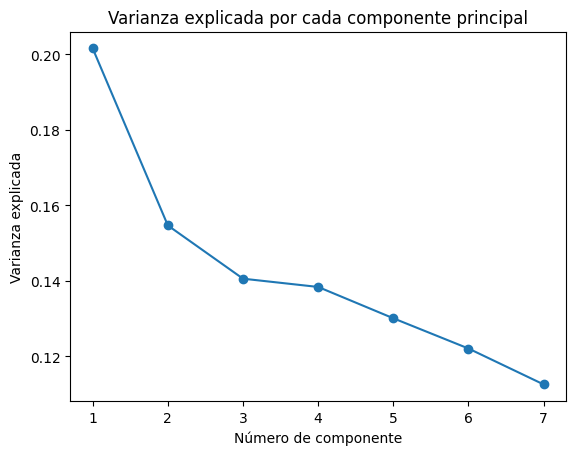

Número de componentes seleccionados: 6
Coeficientes principales (cargas):
[[ 0.33090516  0.47909721  0.56157958  0.4601139   0.32030089 -0.13221938
  -0.11754397]
 [ 0.2075987   0.07678951 -0.02256641  0.20702567 -0.53089969 -0.44509356
   0.65396829]
 [ 0.61447748  0.20316511 -0.00177393 -0.21206033 -0.409668    0.60232371
  -0.07447759]
 [-0.32133227  0.09277895 -0.01526032  0.33720999  0.20771779  0.62819585
   0.58001506]
 [-0.55898029  0.68178002  0.03194494 -0.11364086 -0.41030742 -0.00354965
  -0.20104114]
 [ 0.0229755  -0.09227264 -0.47737787  0.74037054 -0.23320732  0.05932976
  -0.39624998]
 [-0.23147507 -0.49127081  0.67451686  0.1602892  -0.42642757  0.15314458
  -0.1382495 ]]


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Supongamos que df es el DataFrame original
df_encoded = df.select_dtypes(include=[np.number]).dropna()  # Asegurar solo valores numéricos y sin NaN

# Estandarizar los datos (media = 0, varianza = 1)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded)

# Realizar PCA
pca = PCA()
pca.fit(df_scaled)

# Varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Mostrar la varianza explicada
print(f'Varianza explicada por cada componente: {explained_variance}')

# Gráfico de varianza explicada
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Varianza explicada por cada componente principal')
plt.xlabel('Número de componente')
plt.ylabel('Varianza explicada')
plt.show()

# Selección de componentes: acumulado ≥ 80% de varianza
cumulative_variance = np.cumsum(explained_variance)
num_components = np.argmax(cumulative_variance >= 0.80) + 1
print(f'Número de componentes seleccionados: {num_components}')

# Obtener los componentes principales
principal_components = pca.components_

# Mostrar los coeficientes principales
print('Coeficientes principales (cargas):')
print(principal_components)



## Conclusiones sobre el Análisis de Componentes Principales (PCA)
1. Adecuación del PCA:
La prueba de esfericidad de Bartlett sugiere que las variables están correlacionadas, lo que indica que el PCA es una técnica adecuada, falta evaluar el índice KMO para confirmar si la muestra es lo suficientemente adecuada para PCA.

2. Cantidad de Componentes Principales:
Se seleccionó un número de componentes basado en la varianza acumulada (≥80%).
Esto garantiza que la mayoría de la información en los datos originales se conserve con un menor número de dimensiones.

3. Explicación de la Variabilidad:
Los primeros componentes principales explican la mayor parte de la variabilidad de los datos, si los primeros 2 o 3 componentes explican una alta proporción de la varianza, se puede reducir la dimensionalidad con una mínima pérdida de información.

4. Interpretación de los Componentes:
Cada componente es una combinación lineal de las variables originales.
Las variables con mayores cargas en el primer componente representan la dirección de máxima variabilidad en los datos, si el segundo componente tiene una alta carga en otras variables, indica que captura una dimensión ortogonal al primer componente.

5. Impacto del PCA:
Permite reducir la dimensionalidad del conjunto de datos, facilitando el análisis y la visualización, ayuda a identificar patrones en los datos, eliminando redundancia y enfocándose en la información más relevante, si útil para modelos de Machine Learning, ya que puede mejorar el rendimiento eliminando características irrelevantes o redundantes.